# Lesson 29: PyTorch CIFAR-10 classifier activity

In this activity, you will build a deep neural network classifier for the CIFAR-10 dataset using PyTorch. The data loading and preparation code is provided. Your task is to:

1. **Define the model** - Build a DNN using `nn.Sequential`
2. **Train the model** - Write a training loop with validation tracking
3. **Evaluate the model** - Assess performance on the test set

## Notebook set-up

### Imports

In [14]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set random seeds for reproducibility
torch.manual_seed(320)
np.random.seed(320)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [15]:
batch_size = 10000
learning_rate = 1e-3
epochs = 100
print_every = 10

## 1. Load and preprocess CIFAR-10 data

CIFAR-10 contains 32x32 color images across 10 classes. We convert the images to grayscale for this exercise.

### 1.1. Define transformations and class names

In [16]:
# Define class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Data preprocessing: convert to grayscale, tensor, and normalize
transformations = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

### 1.2. Load datasets

In [17]:
# Make sure data directory exists
data_dir = Path('./data')
data_dir.mkdir(parents=True, exist_ok=True)

# Load training and test datasets
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transformations
)

test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transformations
)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Number of classes: {len(class_names)}')

Training samples: 50000
Test samples: 10000
Image shape: torch.Size([1, 32, 32])
Number of classes: 10


### 1.3. Pre-load data and create data loaders

In [18]:
# Pre-load entire dataset to device for faster training
X_train_full = torch.stack([img for img, _ in train_dataset]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset]).to(device)

X_test = torch.stack([img for img, _ in test_dataset]).to(device)
y_test = torch.tensor([label for _, label in test_dataset]).to(device)

# Split training data into train and validation sets (80/20 split)

n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train = X_train_full[indices[:n_train]]
y_train = y_train_full[indices[:n_train]] #.to(torch.long)
X_val = X_train_full[indices[n_train:]]
y_val = y_train_full[indices[n_train:]] #.to(torch.long)

print(f'X_train shape: {X_train.shape}, device: {X_train.device}')
print(f'y_train shape: {y_train.shape}, device: {y_train.device}')
print(f'X_val shape: {X_val.shape}, device: {X_val.device}')
print(f'y_val shape: {y_val.shape}, device: {y_val.device}')
print(f'X_test shape: {X_test.shape}, device: {X_test.device}')
print(f'y_test shape: {y_test.shape}, device: {y_test.device}')

X_train shape: torch.Size([40000, 1, 32, 32]), device: cuda:0
y_train shape: torch.Size([40000]), device: cuda:0
X_val shape: torch.Size([10000, 1, 32, 32]), device: cuda:0
y_val shape: torch.Size([10000]), device: cuda:0
X_test shape: torch.Size([10000, 1, 32, 32]), device: cuda:0
y_test shape: torch.Size([10000]), device: cuda:0


In [19]:
# Create TensorDatasets
train_tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(
    train_tensor_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 4
Validation batches: 1
Test batches: 1


### 1.4. Visualize sample images

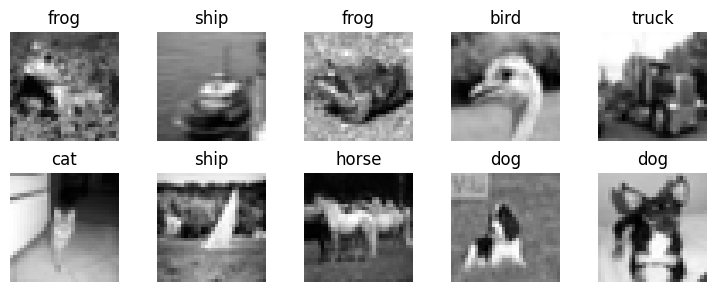

In [20]:
# Get a batch of training images
images, labels = next(iter(train_loader))

# Plot first 10 images
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):

    img = images[i].cpu() * 0.5 + 0.5
    img = img.numpy().squeeze()
    ax.set_title(class_names[labels[i]])
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 2. Build DNN classifier

### Task 1: Define model architecture

Build a fully connected neural network using `nn.Sequential` to classify CIFAR-10 images.

**Requirements:**
- Flatten the input images (32x32x1 = 1024 features)
- Use at least 2 hidden layers with ReLU activation
- Add dropout for regularization
- Output layer should have 10 units (one per class)

**Hints:**
- Use `nn.Flatten()` as the first layer to convert images to vectors
- Use `nn.Linear(in_features, out_features)` for fully connected layers
- Use `nn.ReLU()` for activation functions
- Use `nn.Dropout(p)` for regularization (e.g., p=0.2)
- Don't forget to move the model to the device with `.to(device)`
- `nn.CrossEntropyLoss` applies softmax internally, so no activation needed on output

In [21]:
input_size = 32 * 32 * 1  # Grayscale image flattened
num_classes = 10
p = 0.3

# Model was WAY TOO large for this data, and was randomly guessing and couldn't train properly
# Need to keep note of this, too many neurons will over-complicate the learning 
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Dropout(p),
    # nn.Linear(512, 256),
    # nn.ReLU(),
    # nn.Dropout(p),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p),
    nn.Linear(64, num_classes)
).to(device)

print(model)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 140106


### Task 2: Define loss function and optimizer

**Hints:**
- Use `nn.CrossEntropyLoss()` for multi-class classification
- Use `optim.Adam(model.parameters(), lr=learning_rate)` as the optimizer

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 3. Training

### Task 3: Write training function

Write a training loop that trains the model and tracks both training and validation metrics.

**Requirements:**
- Iterate over epochs
- For each epoch, iterate over batches in the training loader
- Track training loss and accuracy
- After training, evaluate on validation set (without gradient computation)
- Track validation loss and accuracy
- Return a history dictionary with all metrics

**Hints:**
- Use `model.train()` before training and `model.eval()` before validation
- Use `optimizer.zero_grad()` to clear gradients before each batch
- Use `loss.backward()` for backpropagation
- Use `optimizer.step()` to update weights
- Use `torch.no_grad()` context manager for validation
- Use `torch.max(outputs, 1)` to get predictions from logits
- Accuracy = 100 * correct / total

In [23]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    print_every: int = 1
) -> dict[str, list[float]]:
    '''Training loop for PyTorch classification model.
    
    1. Training phase - iterate over train_loader batches
    2. Validation phase - evaluate on val_loader after each epoch
    3. Track and return history of train_loss, val_loss, train_accuracy, val_accuracy
    '''

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):

        # - Set model to training mode
        # - Loop over batches in train_loader
        # - For each batch: zero gradients, forward pass, compute loss, backward pass, update weights
        # - Track running loss and accuracy
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        n_batches = 0
        n_batches_val = 0
        train_correct = 0
        train_total = 0
        val_correct = 0
        val_total = 0
        
        model.train()
        

        # for (X_train, y_train), (X_val, y_val) in zip(train_loader, val_loader):
        for X_train_batch, y_train_batch in train_loader:
            # X_train_batch = X_train_batch.to(device)
            # y_train_batch = y_train_batch.to(device)


            #Forward Pass
            optimizer.zero_grad()
            train_predictions = model(X_train_batch)
            train_loss = criterion(train_predictions, y_train_batch)

            #Backward Pass
            train_loss.backward()
            optimizer.step()

            #Sum training loss
            epoch_train_loss += train_loss.item()

            #Calculate val loss
            # val_predictions = model(X_val)
            # val_loss = criterion(val_predictions, y_val)
            # epoch_val_loss += val_loss.item()

            #Calculate accuracy
            _,preds = torch.max(train_predictions,1)
            train_correct += (preds ==y_train_batch).sum().item()
            train_total += y_train_batch.shape[0]

            n_batches += 1

        

        # - Set model to evaluation mode
        # - Use torch.no_grad() context
        # - Loop over batches in val_loader
        # - Compute loss and accuracy (no gradient computation needed)
        model.eval()

        #Make predictions (no gradient calc needed)
        
            # predictions = model(X_test).cpu().numpy().flatten()

        for X_val_batch, y_val_batch in val_loader:
            with torch.no_grad():
                # X_val_batch = X_val_batch.to(device)
                # y_val_batch = y_val_batch.to(device)


                val_predictions = model(X_val_batch)#.cpu().numpy().flatten()
                val_loss = criterion(val_predictions, y_val_batch)
                epoch_val_loss += val_loss.item()

                #Calculate accuracy
                _,preds = torch.max(val_predictions,1)
                val_correct += (preds == y_val_batch).sum().item()
                val_total += y_val_batch.shape[0]

                n_batches_val += 1


        # Average training loss for the epoch
        history['train_loss'].append(epoch_train_loss / n_batches)
        history['train_accuracy'].append(100 * (train_correct / train_total))

        # Average val loss for the epoch
        # history['val_loss'].append(epoch_val_loss / len(val_loader))
        history['val_loss'].append(epoch_val_loss / n_batches_val)
        history['val_accuracy'].append(100 * (val_correct / val_total))

        # Print progress
        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{epochs}] - '
                  f'Train Loss: {history["train_loss"][-1]:.4f} - '
                  f'Val Loss: {history["val_loss"][-1]:.4f} - '
                  f'Train Accuracy: {history["train_accuracy"][-1]:.4f} - '
                  f'Val Accuracy: {history["val_accuracy"][-1]:.4f} - ')

    print('\nTraining complete.')

    return history

In [24]:
#For debug purposes
# device = "cpu"
# model.to(device)

### Task 4: Train the model

In [25]:
# Call your training function
# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    print_every=print_every
)

Epoch [10/100] - Train Loss: 1.9578 - Val Loss: 1.8874 - Train Accuracy: 30.3700 - Val Accuracy: 33.7300 - 
Epoch [20/100] - Train Loss: 1.8441 - Val Loss: 1.7855 - Train Accuracy: 35.2050 - Val Accuracy: 37.5500 - 
Epoch [30/100] - Train Loss: 1.7717 - Val Loss: 1.7158 - Train Accuracy: 37.7775 - Val Accuracy: 39.9400 - 
Epoch [40/100] - Train Loss: 1.7000 - Val Loss: 1.6610 - Train Accuracy: 40.2625 - Val Accuracy: 41.9000 - 
Epoch [50/100] - Train Loss: 1.6564 - Val Loss: 1.6255 - Train Accuracy: 41.9300 - Val Accuracy: 43.2200 - 
Epoch [60/100] - Train Loss: 1.6088 - Val Loss: 1.6010 - Train Accuracy: 43.1700 - Val Accuracy: 43.6000 - 
Epoch [70/100] - Train Loss: 1.5679 - Val Loss: 1.5759 - Train Accuracy: 45.0175 - Val Accuracy: 44.3700 - 
Epoch [80/100] - Train Loss: 1.5326 - Val Loss: 1.5638 - Train Accuracy: 45.9100 - Val Accuracy: 44.5800 - 
Epoch [90/100] - Train Loss: 1.5045 - Val Loss: 1.5539 - Train Accuracy: 46.8225 - Val Accuracy: 45.1400 - 
Epoch [100/100] - Train Loss

### Task 5: Plot learning curves

**Hints:**
- Create a 1x2 subplot for loss and accuracy
- Plot both training and validation metrics on each subplot
- Add legends to distinguish the curves

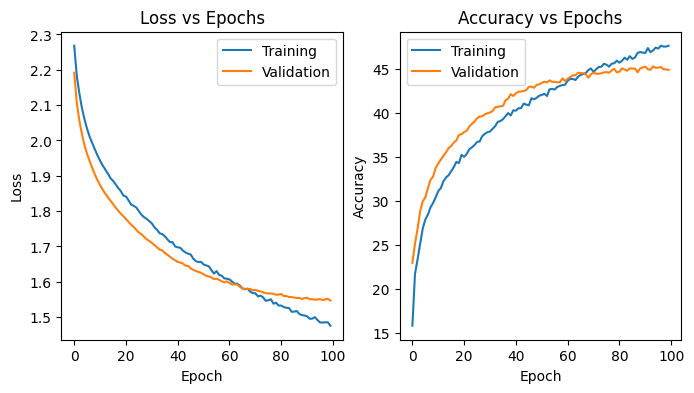

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# - Left plot: training and validation loss over epochs
axes[0].set_title('Loss vs Epochs')
axes[0].plot(history['train_loss'], label='Training')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')
# - Right plot: training and validation accuracy over epochs
axes[1].set_title('Accuracy vs Epochs')
axes[1].plot(history['train_accuracy'], label='Training')
axes[1].plot(history['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc="best")


plt.show()

## 4. Evaluate model on test set

### Task 6: Write evaluation function

Write a function to evaluate the model on the test set and return accuracy and predictions.

**Hints:**
- Set model to evaluation mode with `model.eval()`
- Use `torch.no_grad()` context
- Iterate over test_loader and accumulate predictions
- Return accuracy, predictions array, and true labels array

In [53]:
def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader
) -> tuple[float, np.ndarray, np.ndarray]:
    '''Evaluate model on test set.
    
    Implement evaluation logic
    Returns: (accuracy, predictions, true_labels)
    '''
    history = {'test_loss':[], 'test_accuracy':[]}
    epoch_test_loss = 0
    test_correct = 0
    test_total = 0

    model.eval()

    #Make predictions (no gradient calc needed)
    for X_test_batch, y_test_batch in test_loader:
        with torch.no_grad():
            test_predictions = model(X_test_batch)#.cpu().numpy().flatten()
            test_loss = criterion(test_predictions, y_test_batch)
            epoch_test_loss += test_loss.item()

            #Calculate accuracy
            _,preds = torch.max(test_predictions,1)
            test_correct += (preds == y_test_batch).sum().item()
            test_total += y_test_batch.shape[0]

    test_accuracy = 100 * (test_correct / test_total)
    history['test_loss'].append(epoch_test_loss / len(test_loader))
    history['test_accuracy'].append(test_accuracy)
    print(history)
    return test_accuracy, test_predictions,y_test_batch


#Call your evaluation function and print test accuracy
test_accuracy, test_predictions, true_labels = evaluate_model(model, test_loader)
print(f'Test accuracy: {test_accuracy:.4f}% - Test Preds: {test_predictions} - True Labels: {true_labels}')

{'test_loss': [1.5450133085250854], 'test_accuracy': [46.98]}
Test accuracy: 46.9800% - Test Preds: tensor([[-0.0771, -3.1371,  0.9843,  ..., -1.1364, -0.0445, -2.7576],
        [ 1.4467,  3.5917, -3.9810,  ..., -6.0110,  4.3655,  4.6657],
        [ 1.9235, -1.8789, -0.6792,  ..., -0.9589,  2.3284, -1.0080],
        ...,
        [-1.8405, -3.7005,  1.2291,  ..., -0.2664, -1.3795, -1.9087],
        [-1.5329,  1.3577, -1.7258,  ..., -1.6060, -1.3851, -1.4778],
        [-1.5481, -0.0356,  0.4237,  ...,  1.1019, -1.9809, -0.8938]],
       device='cuda:0') - True Labels: tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0')
